# Two neuron dynamics analysis

In this notebook we are going to study the behaviour of synaptical modelling in two conductance based neuron models  

In [1]:
import numpy as np
from scipy.integrate import odeint
from functools import partial
import matplotlib

matplotlib.rcParams.update({
    'font.family': 'serif',
})

In [2]:
# global single cell parameters
ena, ek, el, esyn = 60, -90, -80, 0
gna, gk, gl = 20, 10, 8 
C, I = 1, 0
vmaxm, vmaxn = -20, -25
km, kn = 15, 5
taun, taus = 1, 5 

# global two cell parameters
vt, vs = 2, 5
As = 1
b1, b2 = 0.25, 0.1
I1, I2 = 0, 0
# g_ext, g_exc, g_inh = 3, 1, 0.1

In [3]:
# Excitation functions
def spike_train(d, rate, dt):
    """ Generates Poisson delta train
    Params:
    d (int): duration in milliseconds of the train
    rate (int): how many firings per second (Hz)
    dt (float): time differential used in the simulation REPLACE THIS IS NOW D/N AS EVERYTHING ELSE!
    Returns:
    result (np.array) with the indexes of the spikes
    """
    n = int(d/dt)
    spikes = np.random.rand(n) < rate/1000*dt # We divide by 1000 bc rate is in Hz
    index = np.where(spikes)[0]
    return index*dt

def alfa(t):
    """ Enveloping function
    For each spike we fire one of these
    """
    return 1/taus**2*t*np.e**(-t/taus)

def step(t):
    """ Returns 0 if t less than 0
    """
    return 1 if t > 0 else 0

def opt_gsyn(t, train):
    """ Excitation function
    Takes a Poisson delta train and generates a sum of enveloping functions (alphas)
    """
    result = 0
    reduced_train = train[(train > (t-40)) & (train < t)]
    for it in reduced_train:
        result += alfa(t-it)*step(t-it)
    return result

# ODE time derivative and assistant functions
def minf(V):
    return 1/(1+np.e**(-(V-vmaxm)/km))

def ninf(V):
    return 1/(1+np.e**(-(V-vmaxn)/kn))

def fpre(v):
    return 1./(1 + np.e**(-(v-vt)/vs))

# Parametric time derivative (Add all the parameters you wanna play with in the arguments of the function)
def twoneurons(X, t, spikes, g_ext, g_inh, g_exc, I1=0, I2=0, cross=False, lamb=1):
    V1, V2, n1, n2, s1, s2 = X
    
    if cross:
        A,B=V2,V1
    else:
        A,B=V1,V2
   
    dV1dt = (I1 - gl*(V1-el) - gna*minf(V1)*(V1-ena) - gk*n1*(V1-ek) - g_inh*s2*(A - (-80)) - g_ext*opt_gsyn(t, spikes)*(A-0))/C # 
    dn1dt = (ninf(V1) - n1)/taun
    
    dV2dt = (I2 - gl*(V2-el) - gna*minf(V2)*(V2-ena) - gk*n2*(V2-ek) - g_exc*s1*(B - 0))/C
    dn2dt = (ninf(V2) - n2)/taun
    
    ds1dt = As * fpre(V1)*(1-s1) - lamb*b1*s1
    ds2dt = As * fpre(V2)*(1-s2) - lamb*b2*s2
    
    return [dV1dt, dV2dt, dn1dt, dn2dt, ds1dt, ds2dt]
    

In [4]:
# This is example time integration of the model
d, n = 200, 500
time_span = np.linspace(0.0, d, n)
spikes = spike_train(d, 50, d/n)

params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 0, 
          'g_inh': 0}

y0 = [-66,-66,0,0,0,0]

run, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)

**INTRODUCING MODULAR PLOTS**

This means plots as a function cause now we are going to do lots of plots this is convenient for mental sanity

In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [6]:
def plot_spikesandgsyn(axis, spikes, time_span):
    # Plot spike lines
    for t in spikes:
        l1 = axis.axvline(x=t, color='darkblue', linestyle='dashed', linewidth=1, label='spike')

    # Compute synaptic excitation
    results = np.zeros(time_span.shape[0])
    for it, t in enumerate(time_span):
        results[it] = (opt_gsyn(t, spikes))

    # And plot it
    l2, = axis.plot(time_span,results, c='r', alpha=0.8, label='g_syn')

    # This is a custom legend (might export this to a function in the future)
    lines = [l1,l2]
    axis.legend(lines, [l.get_label() for l in lines])

    axis.set(ylabel="$g_{syn}$ $(mS/cm^2)$",xlabel="time $(ms)$")
    axis.grid()
    
    return axis

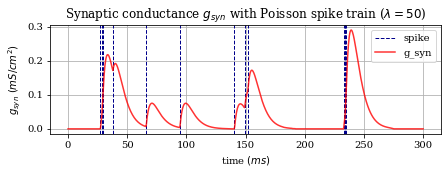

In [7]:
# Example spike and gsyn plot
d, n = 300, 800
time_span = np.linspace(0.0, d, n)
spikes = spike_train(d, 50, d/n)

fig, ax = plt.subplots(1,1, figsize=(7,2))

plot_spikesandgsyn(axis=ax, spikes=spikes, time_span=time_span)

ax.set(title="Synaptic conductance $g_{syn}$ with Poisson spike train ($\lambda = 50$)")

plt.savefig('./img/g_syn.pdf')

In [8]:
def plot_neuron(axis, time_span, signals, n_num, set_time=False):
    
    # Plotting signal 1 in left axis and signal 2 in right axis
    l1, = axis.plot(time_span, signals[0] , c='tab:blue', label=f'$V_{{{n_num}}}$', lw=2.0)
    axis2 = axis.twinx()
    axis2.set(ylabel=f'$s_{{{n_num}}}$')
    l2, = axis2.plot(time_span, signals[1] , c='tab:orange', label=f'$s_{{{n_num}}}$', alpha=0.8)
    
    # Set labels
    axis.set(ylabel=f"$V_{{{n_num}}}$ (mv)")
    if set_time:
        axis.set(xlabel="time (ms)")
    
    # This sets up the legend
    lines = [l1,l2]
    axis.legend(lines, [l.get_label() for l in lines])
    
    # Activate grid
    axis.grid()

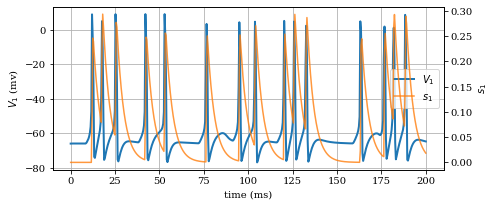

In [9]:
# Example spike and gsyn plot
d, n = 200, 500
time_span = np.linspace(0.0, d, n)
spikes = spike_train(d, 50, d/n)

fig, ax = plt.subplots(1,1, figsize=(7,3))

params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 0, 
          'g_inh': 0}

y0 = [-66,-66,0,0,0,0]

run, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)

plot_neuron(axis=ax, time_span=time_span, signals=[run[:,0],run[:,4]], n_num=1, set_time=True)

fig.show()

In [22]:
# Now a plot that actually means something
def plot_completetwoneurons(time_span, spikes, run, figsize=(7,7), hr = [2, 2, 1], title=None, plotA=True, plotB=True):
    fig, ax = plt.subplots(3,1, figsize=figsize, sharex=True, gridspec_kw={ 'height_ratios': hr,
                                                                      'wspace':0, 
                                                                      'hspace':0.2 })
    # This is to set same formatting (look good!)
    for a in ax: a.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) 

    plot_spikesandgsyn(axis=ax[2], spikes=spikes, time_span=time_span)

    if plotA:
        plot_neuron(axis=ax[0], time_span=time_span, signals=[run[:,0],run[:,4]], n_num=1)
    if plotB:
        plot_neuron(axis=ax[1], time_span=time_span, signals=[run[:,1],run[:,5]], n_num=2)
    
    # Set big title
    if not title:
        pars = [f'{name}={params[name]}' for name in list(params.keys())[1:]]
        fig.suptitle(f'Temporal run two neuron model with {pars}', y=0.93)
    else:
        fig.suptitle(title, y=0.93)


    fig.tight_layout()
    
    return fig, ax

<ipython-input-14-1fa1d550c7f5>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


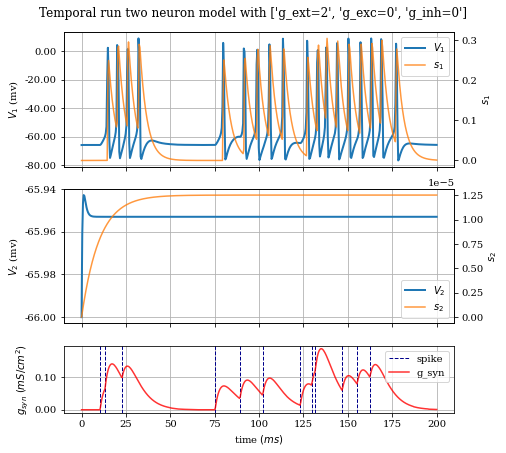

In [15]:
# Example meaningful plot
d, n = 200, 500
time_span = np.linspace(0.0, d, n)
spikes = spike_train(d, 50, d/n)

params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 0, 
          'g_inh': 0}

y0 = [-66,-66,0,0,0,0]

run, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)

fig, ax = plot_completetwoneurons(time_span, spikes, run)

fig.show()

**Now the experiments**

We set up a fixed spike train and let's see

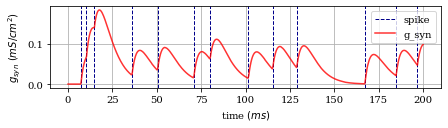

In [29]:
d, n = 200, 500
time_span = np.linspace(0.0, d, n)
spikes = spike_train(d, 60, d/n)

fig, ax = plt.subplots(1,1, figsize=(7,1.5))
plot_spikesandgsyn(axis=ax, spikes=spikes, time_span=time_span)
fig.show()

Standard runs with different synaptical parameters

<ipython-input-14-1fa1d550c7f5>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


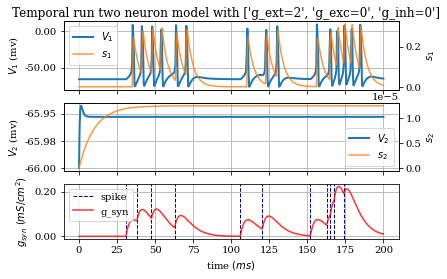

In [17]:
# FIRST CASE SYNAPTICAL TO ZERO
# expected behaviour as no synaptical behavior
params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 0, 
          'g_inh': 0}

y0 = [-66,-66,0,0,0,0]

run, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)

fig, ax = plot_completetwoneurons(time_span, spikes, run, figsize=(6,4), hr=[1,1,0.8])

plt.savefig('./img/two_neurons_relax.pdf')

<ipython-input-14-1fa1d550c7f5>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


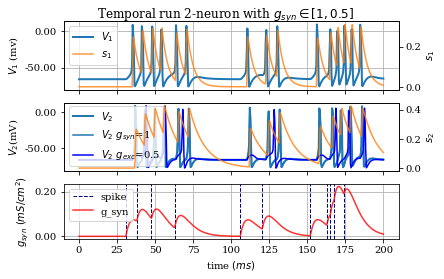

In [18]:
# SECOND CASE SYNAPTICAL EXCITATION TO 1
# It is weird that v1 and v2 are the exact same

params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 1, 
          'g_inh': 0}

y0 = [-66,-66,0,0,0,0]

run, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)

fig, ax = plot_completetwoneurons(time_span, spikes, run, figsize=(6,4), hr=[1,1,0.8], title='Temporal run 2-neuron with $g_{syn} \in [1,0.5]$ ')

params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 0.5, 
          'g_inh': 0}

y0 = [-66,-66,0,0,0,0]

run2, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)

ax[1].plot(time_span, run[:,1], ls='solid', c='tab:blue', label='$V_2$ $g_{syn}$=1')
ax[1].plot(time_span, run2[:,1], c='blue', ls='solid', label='$V_2$ $g_{exc}$=0.5')

ax[1].legend()
ax[1].grid()
ax[1].set(ylabel='$V_2$(mV)')

plt.savefig('./img/two_neurons_exc1.pdf')

<ipython-input-14-1fa1d550c7f5>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


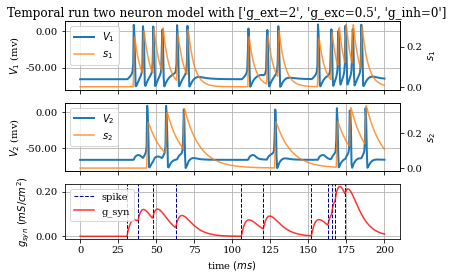

In [19]:
# SECOND CASE SYNAPTICAL EXCITATION TO 1
# It is weird that v1 and v2 are the exact same

params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 0.5, 
          'g_inh': 0}

y0 = [-66,-66,0,0,0,0]

run, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)

fig, ax = plot_completetwoneurons(time_span, spikes, run, figsize=(6,4), hr=[1,1,0.8])

plt.savefig('./img/two_neurons_exc2.pdf')

<ipython-input-14-1fa1d550c7f5>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


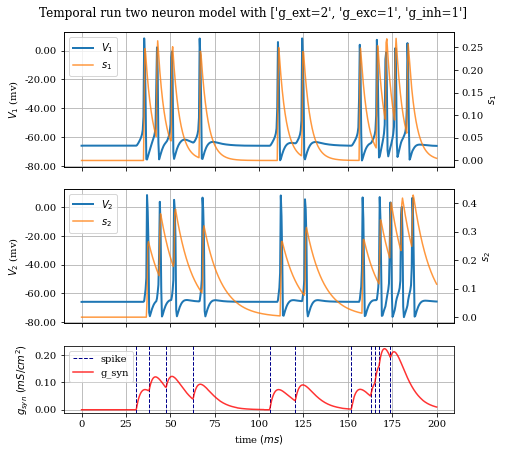

In [20]:
# THIRD CASE SYNAPTICAL EXCITATION AND INHIBITION TO 1
# Realize that now there are less spikes, but still same v1 and v2 behaviour

params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 1, 
          'g_inh': 1}

y0 = [-66,-66,0,0,0,0]

run, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)

fig, ax = plot_completetwoneurons(time_span, spikes, run)

fig.show()

What if we add an external current $I_{app}$?

<ipython-input-22-c49e91c46bc8>:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


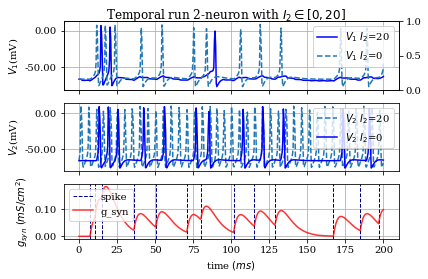

In [32]:
# FIRST EXPERIMENT: HIGH CURRENT IN I2 WITH COMPLETE SYNAPTICAL ACTIVITY
# expected behaviour as N2 depresses neuron 1 a lot
params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 1, 
          'g_inh': 1,
          'I1':0,
          'I2':20,
         }

y0 = [-66,-66,0,0,0,0]

run, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)

params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 1, 
          'g_inh': 1,
          'I1':0,
          'I2':0,
         }

y0 = [-66,-66,0,0,0,0]

run2, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)

fig, ax = plot_completetwoneurons(time_span, spikes, run, figsize=(6,4), hr=[1,1,0.8], title="Temporal run 2-neuron with $I_2 \in [0,20]$", plotA=False, plotB=False)

ax[0].plot(time_span, run[:,0], ls='solid', c='b', label='$V_1$ $I_2$=20')
ax[0].plot(time_span, run2[:,0], c='tab:blue', ls='--', label='$V_1$ $I_2$=0')

ax[0].legend()
ax[0].grid()
ax[0].set(ylabel='$V_1$(mV)')

ax[1].plot(time_span, run[:,1], c='tab:blue', ls='--', label='$V_2$ $I_2$=20')
ax[1].plot(time_span, run2[:,1], c='b', label='$V_2$ $I_2$=0')

ax[1].legend()
ax[1].grid()
ax[1].set(ylabel='$V_2$(mV)')

ax2 = ax[0].twinx()
#ax2.plot(time_span, run[:,4], c='tab:orange', alpha = 0.6, ls='--')

plt.savefig('./img/two_neurons_inh.pdf')

<ipython-input-12-15fd8f655a6b>:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


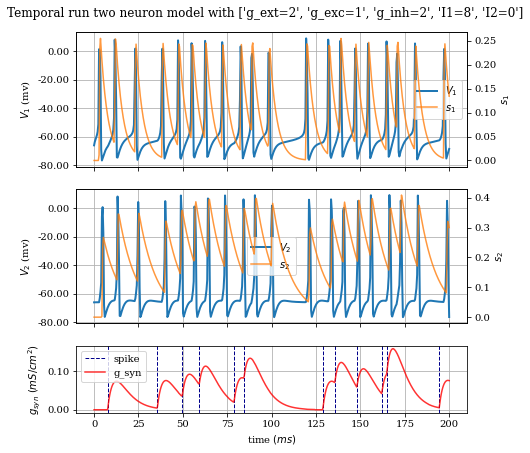

In [20]:
# SECOND EXPERIMENT: MEDIUM CURRENT IN I1 WITH COMPLETE SYNAPTICAL ACTIVITY
# nothing remarcable N1 excites N2 and we see everything in N2
# if we vary g_inh we see that controls the number of spikes in both neurons
params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 1, 
          'g_inh': 2,
          'I1':8,
          'I2':0,
         }

y0 = [-66,-66,0,0,0,0]

run, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)

fig, ax = plot_completetwoneurons(time_span, spikes, run)

fig.show()

What if we cross V1 and V2 voltage for excitation? Does it make sense?

<ipython-input-22-c49e91c46bc8>:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


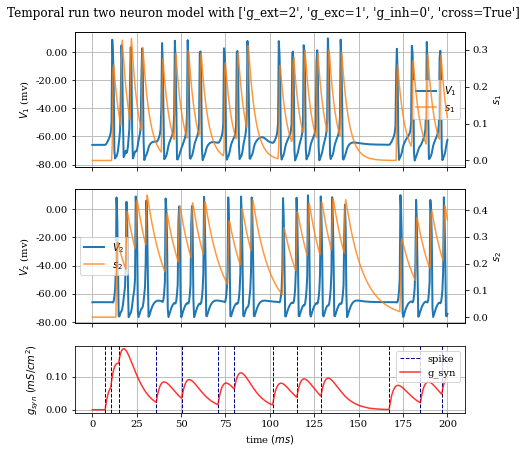

In [33]:
# FIRST EXPERIMENT: CROSSED VOLTAGES ONLY EXCITATION
# It looks like they replicate
# second though can't cross s1 and s2 as the second starts at zero it would cancel everything
params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 1, 
          'g_inh': 0,
          'cross': True,
         }

y0 = [-66,-66,0,0,0,0]

run, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)

fig, ax = plot_completetwoneurons(time_span, spikes, run)

fig.show()

<ipython-input-22-c49e91c46bc8>:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


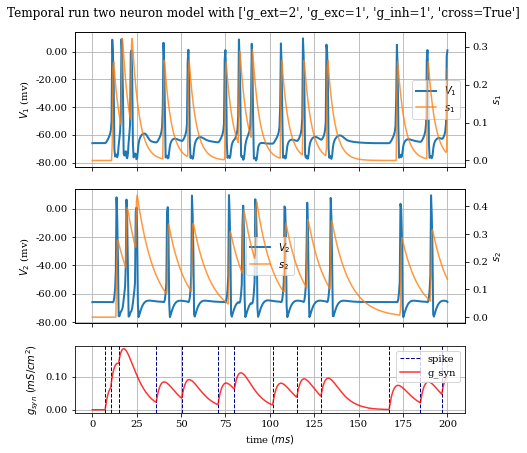

In [34]:
# SECOND EXPERIMENT: CROSSED VOLTAGES COMPLETE SYNAPSE 
# I am starting to think it doesn't make much sense
# It divides by two the number of spikes in both cases
params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 1, 
          'g_inh': 1,
          'cross': True,
         }

y0 = [-66,-66,0,0,0,0]

run, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)

fig, ax = plot_completetwoneurons(time_span, spikes, run)

fig.show()

**Exercise A** Try different values of g_inh and comment the results

In [142]:
y0 = [-66,-66,0,0,0,0]
          
d, n = 300, 3000
time_span = np.linspace(0.0, d, n)
spikes = spike_train(d, 50, d/n)

# Three scenarios with three different g_inh
params = [{'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 1, 
          'g_inh': 0,
          },
          {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 1, 
          'g_inh': 1,
          },
          {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 1, 
          'g_inh': 2,
          }]

store = np.zeros((3,n,6))
          
for ix, scenario in enumerate(params):
    store[ix, :] = odeint(partial(twoneurons, **scenario), y0=y0, t=time_span)

In [143]:
from collections import Counter
import os.path

def count_peaks(temporal_series, thr):
    # List of values
    values = temporal_series>-thr
    values = values.astype('int')
    # Computes the crossing 1: ascendent -1: descendent
    difference = values[1:]-values[:-1]
    # Count the number of 1 (ascendent crossings)
    peaks = Counter(difference)[1]
    
    return peaks

<ipython-input-149-a3c8dd3b4d60>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


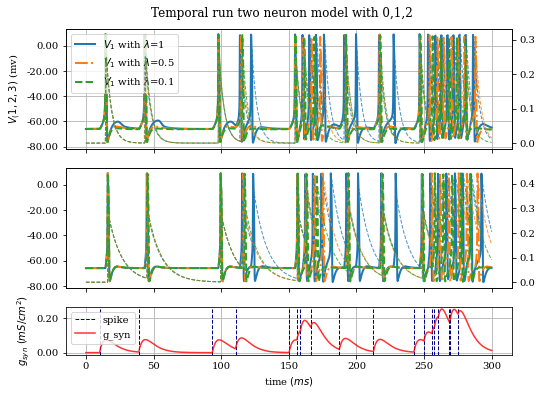

In [149]:
fig, ax = plt.subplots(3,1, figsize=(8,6), sharex=True, gridspec_kw={ 'height_ratios': [2.5, 2.5, 1],
                                                                      'wspace':0, 
                                                                      'hspace':0.2 })
# This is to set same formatting (look good!)
for a in ax: a.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) 
        
colors = ['tab:blue','tab:orange','tab:green']
lines = ['solid', '-.', '--']
ax2 = ax[0].twinx()
for i in range(3):
    ax[0].plot(time_span[:], store[i,:,0], c=colors[i], alpha=1,
               label=f"$V_1$ with $\lambda$={[1,0.5,0.1][i]}", lw=2.0, ls=lines[i])
    ax2.plot(time_span[:], store[i,:,4], c=colors[i], alpha=0.8,
               label=f"$s_1$ with $\lambda$={[1,0.5,0.1][i]}", lw=1.0, ls='--')
ax2 = ax[1].twinx()
for i in range(3):
    ax[1].plot(time_span[:], store[i,:,1], c=colors[i], alpha=1,
               label=f"$V_1$ with $\lambda$={[1,0.5,0.1][i]}", lw=2.0, ls=lines[i])
    ax2.plot(time_span[:], store[i,:,5], c=colors[i], alpha=0.8,
               label=f"$s_1$ with $\lambda$={[1,0.5,0.1][i]}", lw=1.0, ls='--')

ax[0].legend()
# Set labels
ax[0].set(ylabel=f"$V_{1,2,3}$ (mv)")
# Activate grid
ax[0].grid()

plot_spikesandgsyn(axis=ax[2], spikes=spikes, time_span=time_span)

# Set big title
fig.suptitle(f'Temporal run two neuron model with 0,1,2', y=0.93)

fig.tight_layout()

In [153]:
# Let's zoom in that messy area...
t1, t2 = 250, 300
i1,i2 = int(t1*n/d),int(t2*n/d)
mod_spikes = spikes[(t1<spikes)&(spikes<t2)]

<ipython-input-155-7b72b37f774e>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


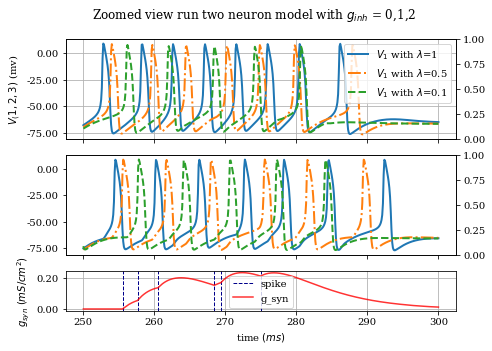

In [155]:
fig, ax = plt.subplots(3,1, figsize=(7,5), sharex=True, gridspec_kw={ 'height_ratios': [2.5, 2.5, 1],
                                                                      'wspace':0, 
                                                                      'hspace':0.2 })
# This is to set same formatting (look good!)
for a in ax: a.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) 
        
colors = ['tab:blue','tab:orange','tab:green']
lines = ['solid', '-.', '--']
ax2 = ax[0].twinx()
for i in range(3):
    ax[0].plot(time_span[i1:i2], store[i,i1:i2,0], c=colors[i], alpha=1,
               label=f"$V_1$ with $\lambda$={[1,0.5,0.1][i]}", lw=2.0, ls=lines[i])
    #ax2.plot(time_span[i1:i2], store[i,i1:i2,4], c=colors[i], alpha=0.8,
    #           label=f"$s_1$ with $\lambda$={[1,0.5,0.1][i]}", lw=1.0, ls='--')
ax2 = ax[1].twinx()
for i in range(3):
    ax[1].plot(time_span[i1:i2], store[i,i1:i2,1], c=colors[i], alpha=1,
               label=f"$V_1$ with $\lambda$={[1,0.5,0.1][i]}", lw=2.0, ls=lines[i])
    #ax2.plot(time_span[i1:i2], store[i,i1:i2,5], c=colors[i], alpha=0.8,
    #           label=f"$s_1$ with $\lambda$={[1,0.5,0.1][i]}", lw=1.0, ls='--')

ax[0].legend()
# Set labels
ax[0].set(ylabel=f"$V_{1,2,3}$ (mv)")
# Activate grid
ax[0].grid()

plot_spikesandgsyn(axis=ax[2], spikes=mod_spikes, time_span=time_span[i1:i2])

# Set big title
fig.suptitle("Zoomed view run two neuron model with $g_{{inh}}$ = 0,1,2", y=0.97)

fig.tight_layout()
plt.savefig('./img/exA.pdf', bbox_inches = "tight")

**Exercise B** Study the impact of changing time constant $1/\beta_i$ by a parameter $\lambda$

In [107]:
y0 = [-66,-66,0,0,0,0]
          
d, n = 400, 4000
time_span = np.linspace(0.0, d, n)
#spikes = spike_train(d, 65, d/n)

# Three scenarios with three different g_inh
params = [{'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 1, 
          'g_inh': 1,
          'lamb': 1,
          },
          {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 1, 
          'g_inh': 1,
          'lamb': 0.5,
          },
          {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 1, 
          'g_inh': 1,
          'lamb': 0.1,
          }]

store = np.zeros((3,n,6))
          
for ix, scenario in enumerate(params):
    store[ix, :] = odeint(partial(twoneurons, **scenario), y0=y0, t=time_span)

In [106]:
spikes = np.array([20,40,60,62,63,66,68])

In [108]:
#spikes = spikes[spikes != 18]
#spikes = np.append(spikes, [18])
spikes

array([20, 40, 60, 62, 63, 66, 68])

<ipython-input-109-8cacef1a2a78>:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


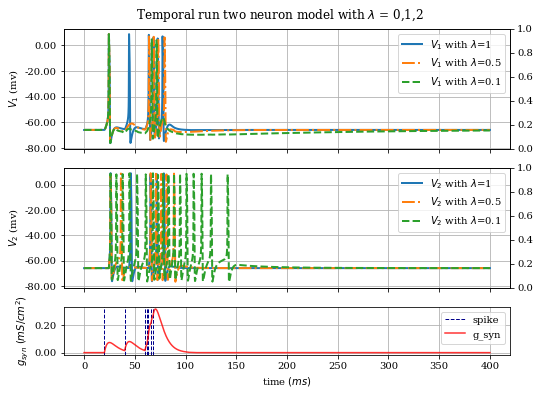

In [109]:
fig, ax = plt.subplots(3,1, figsize=(8,6), sharex=True, gridspec_kw={ 'height_ratios': [2.5,2.5, 1],
                                                                      'wspace':0, 
                                                                      'hspace':0.2 })
# This is to set same formatting (look good!)
for a in ax: a.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) 
        
colors = ['tab:blue','tab:orange','tab:green']
lines = ['solid', '-.', '--']
ax2 = ax[0].twinx()
for i in range(3):
    ax[0].plot(time_span[:], store[i,:,0], c=colors[i], alpha=1,
               label=f"$V_1$ with $\lambda$={[1,0.5,0.1][i]}", lw=2.0, ls=lines[i])
    #ax2.plot(time_span[:], store[i,:,4], c=colors[i], alpha=0.8,
    #           label=f"$s_1$ with $\lambda$={[1,0.5,0.1][i]}", lw=1.0, ls='--')
ax2 = ax[1].twinx()
for i in range(3):
    ax[1].plot(time_span[:], store[i,:,1], c=colors[i], alpha=1,
               label=f"$V_2$ with $\lambda$={[1,0.5,0.1][i]}", lw=2.0, ls=lines[i])
    #ax2.plot(time_span[:], store[i,:,5], c=colors[i], alpha=0.8,
    #           label=f"$s_1$ with $\lambda$={[1,0.5,0.1][i]}", lw=1.0, ls='--')
    
ax[1].legend()
ax[0].legend()
# Set labels
ax[1].set(ylabel=f"$V_2$ (mv)")
ax[0].set(ylabel=f"$V_1$ (mv)")
# Activate grid
ax[1].grid()
ax[0].grid()

plot_spikesandgsyn(axis=ax[2], spikes=spikes, time_span=time_span)

# Set big title
fig.suptitle(f'Temporal run two neuron model with $\lambda$ = 0,1,2', y=0.93)

fig.tight_layout()

In [112]:
# Let's zoom in that messy area...
t1, t2 = 0, 140
i1,i2 = int(t1*n/d),int(t2*n/d)
mod_spikes = spikes[(t1<spikes)&(spikes<t2)]

<ipython-input-116-05d7e05547c4>:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


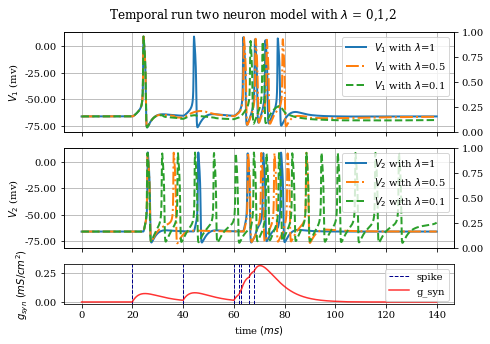

In [116]:
fig, ax = plt.subplots(3,1, figsize=(7,5), sharex=True, gridspec_kw={ 'height_ratios': [2.5, 2.5, 1],
                                                                      'wspace':0, 
                                                                      'hspace':0.2 })
# This is to set same formatting (look good!)
for a in ax: a.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) 
        
colors = ['tab:blue','tab:orange','tab:green']
lines = ['solid', '-.', '--']
ax2 = ax[0].twinx()
for i in range(3):
    ax[0].plot(time_span[i1:i2], store[i,i1:i2,0], c=colors[i], alpha=1,
               label=f"$V_1$ with $\lambda$={[1,0.5,0.1][i]}", lw=2.0, ls=lines[i])
    #ax2.plot(time_span[i1:i2], store[i,i1:i2,4], c=colors[i], alpha=0.8,
    #           label=f"$s_1$ with $\lambda$={[1,0.5,0.1][i]}", lw=1.0, ls='--')
ax2 = ax[1].twinx()
for i in range(3):
    ax[1].plot(time_span[i1:i2], store[i,i1:i2,1], c=colors[i], alpha=1,
               label=f"$V_2$ with $\lambda$={[1,0.5,0.1][i]}", lw=2.0, ls=lines[i])
    #ax2.plot(time_span[:], store[i,:,5], c=colors[i], alpha=0.8,
    #           label=f"$s_1$ with $\lambda$={[1,0.5,0.1][i]}", lw=1.0, ls='--')
    
ax[1].legend()
ax[0].legend()
# Set labels
ax[1].set(ylabel=f"$V_2$ (mv)")
ax[0].set(ylabel=f"$V_1$ (mv)")
# Activate grid
ax[1].grid()
ax[0].grid()

plot_spikesandgsyn(axis=ax[2], spikes=mod_spikes, time_span=time_span[i1:i2])

# Set big title
fig.suptitle(f'Temporal run two neuron model with $\lambda$ = 0,1,2', y=0.95)

fig.tight_layout()
plt.savefig('./img/exB2.pdf', bbox_inches = "tight")